In [281]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [35]:
df = pd.read_csv('athletes.csv')
df.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [8]:
#проверим
for column in df.columns:
    print(f'В солбце {column} - {pd.isnull(df[column]).sum()} пустых')   

В солбце id - 0 пустых
В солбце name - 0 пустых
В солбце nationality - 0 пустых
В солбце sex - 0 пустых
В солбце dob - 1 пустых
В солбце height - 330 пустых
В солбце weight - 659 пустых
В солбце sport - 0 пустых
В солбце gold - 0 пустых
В солбце silver - 0 пустых
В солбце bronze - 0 пустых


In [46]:
# обнулим пустые
for i in ['dob' , 'height' , 'weight' ]:
    df.loc[pd.isnull(df[i ]),i] = 0

In [17]:
#проверим еще раз
for column in ['dob' , 'height' , 'weight' ]:
    print(f'В солбце {column} - {pd.isnull(df[column]).sum()} пустых')   

В солбце dob - 0 пустых
В солбце height - 0 пустых
В солбце weight - 0 пустых


In [57]:
from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder
scaler = StandardScaler()
label_enc = LabelEncoder()
onehot_dummy = OneHotEncoder(handle_unknown='ignore')

In [23]:
y = np.array(df.sex)
y = label_enc.fit_transform(y)
y , label_enc.classes_

(array([1, 0, 1, ..., 1, 1, 1]), array(['female', 'male'], dtype=object))

In [ ]:
# Дропнем, 'у' и то, что мы не буде использовать:
df.drop(['sex', 'id', 'name'], axis=1,inplace=True)

In [189]:
# добавим возраст в выборку
df.dob = pd.to_datetime(df.dob, format='%m/%d/%y',errors='coerce')
df['years'] = df.dob.apply(lambda x: 2021 - x.year )
df.loc[np.isnan(df.years),'years'] = 0

In [190]:
# Соберем Х
X = np.array(df[ ['height','weight','years','gold','silver','bronze' ] ])
a = onehot_dummy.fit_transform( df[  ['nationality','sport' ]]  ).toarray()
X = np.concatenate((X,a), axis=1)
del a
X.shape

(11538, 241)

In [194]:
# Проверим на NaN
X[np.isnan(X)]

array([], dtype=float64)

In [346]:
# Разобъем на трейн тест 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=7)
# Нормализуем первые два столбца - вес и рост
X_train[:,:3] = scaler.fit_transform(X_train[:,:3])
X_test[:,:3] = scaler.fit_transform(X_test[:,:3])

### LogisticRegression

In [170]:
from sklearn.linear_model import LogisticRegression

In [221]:
logit = LogisticRegression(penalty='l2',solver='saga',max_iter=2000,n_jobs=-1)

In [222]:
logit.fit(X_train, y_train)

LogisticRegression(max_iter=2000, n_jobs=-1, solver='saga')

In [223]:
results = logit.predict_proba(X_test)

In [327]:
a = np.concatenate( onehot_dummy.categories_)
columns = np.concatenate( (['height','weight','years','gold','silver','bronze' ],a ))

In [344]:
res = pd.DataFrame( data=logit.coef_,columns=columns).T
res = res.sort_values(by=[0],ascending=False)
res.head()

,0
boxing,7.390198
NOR,2.280372
weight,2.019700
LBA,1.963279
BOT,1.953384


Говорит о том, чтобы разграничить мужчин (у=1) от женщин большое значение имеют:
- вид спорта бокс
- страна Норвегия
- вес
- страна Ливия
- страна Ботсвана


### Confusion Matrix

In [347]:
def how_much_is_the_fish(y_pred_, y_test_, thres = .5,printing=True):
    TP, TN, FP, FN = 0, 0, 0, 0

    for i in range(len(y_test_)):
        if y_pred_[i,1] > thres: 
            if y_test_[i] == 1 : TP +=1
            else: FP +=1
        else: 
            if y_test_[i] == 0 : TN +=1
            else: FN +=1

    if printing: print_conf_matrix(TP, TN, FP, FN)
    return TP, TN, FP, FN

In [348]:
def print_conf_matrix(TP_, TN_, FP_, FN_ ):
    print('\t\tTrue (Actual) ')
    print( '\t|\t +  \t|\t - ')
    print('-'*40)
    print(f'Pred_+\t|\t{TP_} \t|\t {FP_}')
    print(f'Pred_-\t|\t{FN_} \t|\t {TN_}')
    print('-'*40)
    print()

In [349]:
# порог 0.5
how_much_is_the_fish(results, y_test, thres = .5)

		True (Actual) 
	|	 +  	|	 - 
----------------------------------------
Pred_+	|	4355 	|	 3625
Pred_-	|	49 	|	 48
----------------------------------------



(4355, 48, 3625, 49)

In [350]:
# Проверим на sklearn
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, (results[:,1]>.5).astype(int))

array([[  48, 3625],
       [  49, 4355]], dtype=int64)

Совпало. 

### ДЗ: 
* Посчитать tpr и fpr в ноутбуке к лекции. Убедиться, что график ROC AUC получается таким же, как и штатными средствами.

* Построить график Precision - Recall на этих же данных.

In [351]:
recall = np.array([])
FPR = np.array([])
precision = np.array([])


for i in np.arange(.01,1.05,.01):   
    TP, TN, FP, FN = how_much_is_the_fish(results, y_test,thres=i,printing=False)
        
    TPR_sensitivity_recall = TP / (TP + FN +1e-6)
    recall = np.append(recall,TPR_sensitivity_recall)
    
    FPR_i = FP / (FP+TN +1e-6)
    FPR = np.append(FPR,FPR_i)
    
    precision_i = TP / (TP + FP +1e-6)
    precision = np.append(precision,precision_i)
#recall, FPR, precision

In [282]:
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, roc_auc_score

In [352]:
fpr, tpr, thes = roc_curve(y_test,results[:,1] )

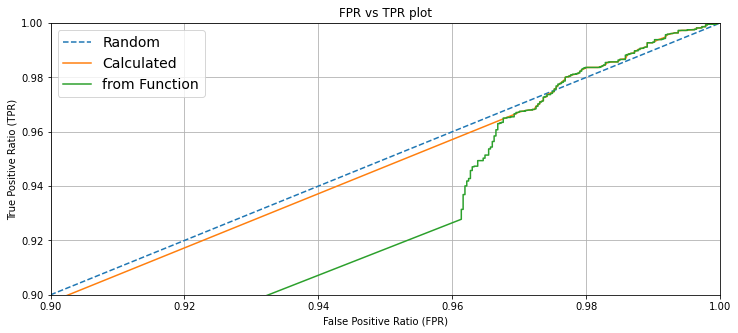

In [353]:
plt.figure(figsize=(12,5))
plt.grid()

plt.plot(np.arange(0,1.1,.1),np.arange(0,1.1,.1),'--',label='Random')
plt.plot(FPR,recall,label='Calculated')
plt.plot(fpr,tpr,label='from Function')

plt.legend(fontsize=14)
plt.title( 'FPR vs TPR plot')
plt.xlabel('False Positive Ratio (FPR)')
plt.ylabel('True Positive Ratio (TPR)')

plt.xlim(0.9,1)
plt.ylim(0.9,1);

In [354]:
# Проверим на сколько корректно выдает значения:
auc(fpr,tpr) , auc(FPR,recall)

(0.4838212631488884, 0.49864226937052164)

Text(0, 0.5, 'Precision')

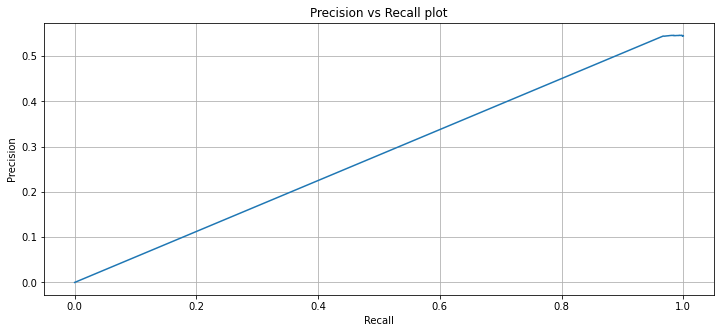

In [355]:
plt.figure(figsize=(12,5))
plt.grid()

plt.plot(recall,precision)

plt.title( 'Precision vs Recall plot')
plt.xlabel('Recall')
plt.ylabel('Precision')


In [356]:
roc_auc_score(y_test, results[:, 1])

0.4838212631488884

Потому что Train / Test split 70% (чтобы значения ошибок были высокие)

### GridSearchCV

In [357]:
from sklearn.model_selection import GridSearchCV

In [373]:
import sklearn
list(sklearn.metrics.SCORERS.keys())

['explained_variance',
 'r2',
 'max_error',
 'neg_median_absolute_error',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_root_mean_squared_error',
 'neg_mean_poisson_deviance',
 'neg_mean_gamma_deviance',
 'accuracy',
 'roc_auc',
 'roc_auc_ovr',
 'roc_auc_ovo',
 'roc_auc_ovr_weighted',
 'roc_auc_ovo_weighted',
 'balanced_accuracy',
 'average_precision',
 'neg_log_loss',
 'neg_brier_score',
 'adjusted_rand_score',
 'homogeneity_score',
 'completeness_score',
 'v_measure_score',
 'mutual_info_score',
 'adjusted_mutual_info_score',
 'normalized_mutual_info_score',
 'fowlkes_mallows_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted']

In [363]:
params = [ {'l1_ratio': list( np.arange(0,1.1,.1) )} ]  

In [374]:
grid_cv = GridSearchCV(LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000, n_jobs=-1), 
                       param_grid=params, scoring='roc_auc', return_train_score=True,
                       cv=10, n_jobs=-1)

In [ ]:
grid_cv.fit( X, y )

In [ ]:
!telegram-send 'Я_посчитал'

In [ ]:
grid_cv.cv_results_

In [ ]:
grid_cv.best_params_